
**Model 1**

This is a basic model of using the val dataset and training the model it does not have any optimisation yet.

This is not the final result. This model is used to show my progess in building the CNN Model.


**Imports**

In [1]:
import os
import time
import copy
import random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from tqdm.auto import tqdm


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Speed settings (deterministic False for faster training)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda available:", torch.cuda.is_available())
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

cuda available: True
Using device: cuda
GPU: Tesla T4


**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Set dataset paths**

In [4]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1"

IMAGES_DIR_CANDIDATES = [
    os.path.join(DATA_ROOT, "data", "images"),
    os.path.join(DATA_ROOT, "images"),
]
IMAGES_DIR = next((cand for cand in IMAGES_DIR_CANDIDATES if os.path.isdir(cand)), None)
if IMAGES_DIR is None:
    raise FileNotFoundError("Images folder not found. Expected 'images/' or 'data/images/' in DATA_ROOT.")

TXT_DIR_CANDIDATES = [os.path.join(DATA_ROOT, "data"), DATA_ROOT]
TXT_DIR = next((cand for cand in TXT_DIR_CANDIDATES if os.path.isfile(os.path.join(cand, "manufacturers.txt"))), None)
if TXT_DIR is None:
    raise FileNotFoundError("manufacturers.txt not found. Expected it in DATA_ROOT or DATA_ROOT/data.")

TRAIN_TXT   = os.path.join(TXT_DIR, "images_manufacturer_train.txt")
VAL_TXT     = os.path.join(TXT_DIR, "images_manufacturer_val.txt")
TEST_TXT    = os.path.join(TXT_DIR, "images_manufacturer_test.txt")
CLASSES_TXT = os.path.join(TXT_DIR, "manufacturers.txt")

print("\nIMAGES_DIR:", IMAGES_DIR)
print("TXT_DIR   :", TXT_DIR)
for p in [TRAIN_TXT, VAL_TXT, TEST_TXT, CLASSES_TXT]:
    print(os.path.basename(p), "->", "OK" if os.path.exists(p) else "MISSING")


IMAGES_DIR: /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/images
TXT_DIR   : /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1
images_manufacturer_train.txt -> OK
images_manufacturer_val.txt -> OK
images_manufacturer_test.txt -> OK
manufacturers.txt -> OK


**Load class names and mapping**

In [5]:
def load_classes(classes_txt: str) -> List[str]:
    with open(classes_txt, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines() if line.strip()]

class_names = load_classes(CLASSES_TXT)
manufacturer_to_idx = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)
print("\nNum classes:", num_classes)

def read_split(txt_path: str) -> List[Tuple[str, int]]:
    samples = []
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(" ")
            image_id = parts[0]
            label_name = " ".join(parts[1:]).strip()
            if label_name not in manufacturer_to_idx:
                raise ValueError(f"Label '{label_name}' not found in manufacturers.txt")
            samples.append((image_id, manufacturer_to_idx[label_name]))
    return samples

train_samples = read_split(TRAIN_TXT)
val_samples   = read_split(VAL_TXT)
test_samples  = read_split(TEST_TXT)

print("Train samples:", len(train_samples))
print("Val samples  :", len(val_samples))
print("Test samples :", len(test_samples))
print("Example train sample:", train_samples[0], "->", class_names[train_samples[0][1]])


Num classes: 30
Train samples: 3334
Val samples  : 3333
Test samples : 3333
Example train sample: ('1025794', 4) -> Boeing


**Read dataset splits**

In [6]:
def remove_copyright_banner(pil_img: Image.Image, banner_px: int = 20) -> Image.Image:
    w, h = pil_img.size
    if h <= banner_px:
        return pil_img
    return pil_img.crop((0, 0, w, h - banner_px))

class FGVCAircraftManufacturerDataset(Dataset):
    def __init__(self, samples: List[Tuple[str, int]], images_dir: str, transform=None, banner_px: int = 20):
        self.samples = samples
        self.images_dir = images_dir
        self.transform = transform
        self.banner_px = banner_px

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, label = self.samples[idx]
        filename = image_id if image_id.lower().endswith(".jpg") else (image_id + ".jpg")
        img_path = os.path.join(self.images_dir, filename)

        img = Image.open(img_path).convert("RGB")
        img = remove_copyright_banner(img, self.banner_px)

        if self.transform:
            img = self.transform(img)

        return img, label

**Transforms (Scratch-friendly)**

In [7]:
IMG_SIZE = 224

NORM_MEAN = [0.5, 0.5, 0.5]
NORM_STD  = [0.5, 0.5, 0.5]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.90, 1.0), ratio=(0.90, 1.10)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

train_ds = FGVCAircraftManufacturerDataset(train_samples, IMAGES_DIR, transform=train_tfms, banner_px=20)
val_ds   = FGVCAircraftManufacturerDataset(val_samples,   IMAGES_DIR, transform=val_tfms,   banner_px=20)
test_ds  = FGVCAircraftManufacturerDataset(test_samples,  IMAGES_DIR, transform=val_tfms,   banner_px=20)

BATCH_SIZE = 64
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

**Scratch ResNet-18 style architecture**

In [8]:
def conv3x3(in_ch, out_ch, stride=1):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_ch, out_ch, 1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ScratchResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_ch = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        self._init_weights()

    def _make_layer(self, out_ch, blocks, stride):
        downsample = None
        if stride != 1 or self.in_ch != out_ch:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        layers = [BasicBlock(self.in_ch, out_ch, stride=stride, downsample=downsample)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_ch, out_ch, stride=1))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = ScratchResNet18(num_classes=num_classes).to(device)
print("\nModel: ScratchResNet18 (NO PRETRAIN)")



Model: ScratchResNet18 (NO PRETRAIN)


**Training utilities**

In [9]:
@dataclass
class History:
    train_loss: list
    val_loss: list
    train_acc: list
    val_acc: list
    train_f1: list
    val_f1: list

def topk_accuracy(logits, labels, k=5):
    topk = logits.topk(k, dim=1).indices
    correct = topk.eq(labels.view(-1, 1)).any(dim=1).float().mean().item()
    return correct

def run_one_epoch(model, loader, criterion, optimizer=None, desc="train"):
    is_train = optimizer is not None
    model.train(is_train)

    running_loss = 0.0
    all_preds, all_labels = [], []
    top5_list = []

    pbar = tqdm(loader, desc=desc, leave=False)
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, labels)
            if is_train:
                loss.backward()
                optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss * images.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

        top5 = topk_accuracy(logits.detach(), labels.detach(), k=5)
        top5_list.append(top5)

        pbar.set_postfix({"loss": f"{batch_loss:.4f}", "top5": f"{top5:.3f}"})

    epoch_loss = running_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    top5_acc = float(np.mean(top5_list)) if len(top5_list) else 0.0

    return epoch_loss, acc, macro_f1, top5_acc

In [10]:
def train_model(model, train_loader, val_loader,
                epochs=60,
                base_lr=0.1,
                weight_decay=5e-4,
                warmup_epochs=5,
                save_path=None):

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(
        model.parameters(),
        lr=base_lr,
        momentum=0.9,
        weight_decay=weight_decay,
        nesterov=True
    )


    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[int(0.6 * epochs), int(0.85 * epochs)],
        gamma=0.1
    )

    best_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = -1.0
    hist = History([], [], [], [], [], [])

    for epoch in range(1, epochs + 1):
        t0 = time.time()

        if epoch <= warmup_epochs:
            lr = base_lr * (epoch / warmup_epochs)
            for pg in optimizer.param_groups:
                pg["lr"] = lr

        tr_loss, tr_acc, tr_f1, tr_top5 = run_one_epoch(
            model, train_loader, criterion, optimizer, desc=f"train {epoch}/{epochs}"
        )
        va_loss, va_acc, va_f1, va_top5 = run_one_epoch(
            model, val_loader, criterion, None, desc=f"val   {epoch}/{epochs}"
        )

        if epoch > warmup_epochs:
            scheduler.step()

        hist.train_loss.append(tr_loss); hist.val_loss.append(va_loss)
        hist.train_acc.append(tr_acc);   hist.val_acc.append(va_acc)
        hist.train_f1.append(tr_f1);     hist.val_f1.append(va_f1)

        improved = va_f1 > best_val_f1
        if improved:
            best_val_f1 = va_f1
            best_wts = copy.deepcopy(model.state_dict())
            if save_path:
                torch.save({
                    "model_state": best_wts,
                    "class_names": class_names,
                    "img_size": IMG_SIZE,
                    "banner_px": 20,
                    "notes": "Model3: ScratchResNet18 + SGD warmup + MultiStepLR (NO PRETRAIN)"
                }, save_path)

        dt = time.time() - t0
        current_lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch}/{epochs} | "
            f"lr {current_lr:.5f} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} top5 {tr_top5:.4f} | "
            f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} top5 {va_top5:.4f} | "
            f"{'BEST' if improved else ''} | {dt:.1f}s"
        )

    model.load_state_dict(best_wts)
    return model, hist

**Train the model**

In [11]:
EPOCHS = 50
BASE_LR = 0.1
WEIGHT_DECAY = 5e-4
WARMUP_EPOCHS = 5

OUT_DIR = os.path.join(DATA_ROOT, "outputs_model3")
os.makedirs(OUT_DIR, exist_ok=True)
CKPT_PATH = os.path.join(OUT_DIR, "model3_best.pt")

model, history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    base_lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
    warmup_epochs=WARMUP_EPOCHS,
    save_path=CKPT_PATH
)

print("\nSaved best checkpoint to:", CKPT_PATH)

train 1/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   1/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | lr 0.02000 | train loss 2.9725 acc 0.1968 f1 0.0305 top5 0.5184 | val loss 4.0024 acc 0.0771 f1 0.0130 top5 0.3718 | BEST | 1983.7s


train 2/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   2/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | lr 0.04000 | train loss 2.7379 acc 0.2337 f1 0.0594 top5 0.6010 | val loss 4.9801 acc 0.0831 f1 0.0127 top5 0.3137 |  | 154.0s


train 3/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   3/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | lr 0.06000 | train loss 2.5936 acc 0.2394 f1 0.0651 top5 0.6246 | val loss 3.7246 acc 0.0867 f1 0.0238 top5 0.3429 | BEST | 152.6s


train 4/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   4/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | lr 0.08000 | train loss 2.4768 acc 0.2594 f1 0.0824 top5 0.6553 | val loss 3.0537 acc 0.2268 f1 0.0371 top5 0.5566 | BEST | 152.1s


train 5/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   5/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | lr 0.10000 | train loss 2.3619 acc 0.2783 f1 0.0989 top5 0.6932 | val loss 2.9646 acc 0.1701 f1 0.0571 top5 0.6282 | BEST | 152.0s


train 6/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   6/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | lr 0.10000 | train loss 2.2086 acc 0.3026 f1 0.1411 top5 0.7350 | val loss 5.6423 acc 0.2187 f1 0.0192 top5 0.5265 |  | 153.2s


train 7/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   7/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | lr 0.10000 | train loss 2.0996 acc 0.3275 f1 0.1760 top5 0.7722 | val loss 2.6530 acc 0.2316 f1 0.0876 top5 0.6778 | BEST | 150.2s


train 8/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   8/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | lr 0.10000 | train loss 1.9632 acc 0.3569 f1 0.2086 top5 0.8018 | val loss 3.9842 acc 0.1776 f1 0.0773 top5 0.6713 |  | 151.5s


train 9/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   9/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | lr 0.10000 | train loss 1.7880 acc 0.4058 f1 0.2843 top5 0.8462 | val loss 5.3372 acc 0.0957 f1 0.0610 top5 0.3587 |  | 149.3s


train 10/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   10/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | lr 0.10000 | train loss 1.6824 acc 0.4382 f1 0.3353 top5 0.8601 | val loss 3.1320 acc 0.1437 f1 0.0699 top5 0.4885 |  | 148.7s


train 11/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   11/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | lr 0.10000 | train loss 1.6592 acc 0.4454 f1 0.3419 top5 0.8707 | val loss 4.4805 acc 0.2247 f1 0.0916 top5 0.5867 | BEST | 150.3s


train 12/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   12/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | lr 0.10000 | train loss 1.5085 acc 0.4907 f1 0.4165 top5 0.8959 | val loss 4.9317 acc 0.2529 f1 0.0643 top5 0.5871 |  | 150.8s


train 13/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   13/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | lr 0.10000 | train loss 1.5050 acc 0.4955 f1 0.3979 top5 0.8945 | val loss 3.6809 acc 0.2505 f1 0.1509 top5 0.7232 | BEST | 150.9s


train 14/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   14/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | lr 0.10000 | train loss 1.2931 acc 0.5591 f1 0.5213 top5 0.9308 | val loss 4.5570 acc 0.1662 f1 0.1100 top5 0.5958 |  | 149.8s


train 15/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   15/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | lr 0.10000 | train loss 1.2237 acc 0.5864 f1 0.5277 top5 0.9400 | val loss 3.2647 acc 0.2907 f1 0.1689 top5 0.7109 | BEST | 149.1s


train 16/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   16/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | lr 0.10000 | train loss 1.0879 acc 0.6236 f1 0.5850 top5 0.9531 | val loss 5.1621 acc 0.1854 f1 0.0836 top5 0.6460 |  | 150.7s


train 17/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   17/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | lr 0.10000 | train loss 1.1536 acc 0.6071 f1 0.5619 top5 0.9455 | val loss 3.7873 acc 0.2253 f1 0.1582 top5 0.7314 |  | 149.2s


train 18/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   18/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | lr 0.10000 | train loss 0.9501 acc 0.6767 f1 0.6484 top5 0.9646 | val loss 3.2450 acc 0.3516 f1 0.2592 top5 0.7400 | BEST | 149.8s


train 19/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   19/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | lr 0.10000 | train loss 0.8446 acc 0.6998 f1 0.6791 top5 0.9721 | val loss 3.2753 acc 0.3396 f1 0.2118 top5 0.7347 |  | 150.6s


train 20/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   20/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | lr 0.10000 | train loss 0.7801 acc 0.7289 f1 0.7084 top5 0.9746 | val loss 3.8140 acc 0.2598 f1 0.1940 top5 0.6590 |  | 149.0s


train 21/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   21/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | lr 0.10000 | train loss 0.6804 acc 0.7735 f1 0.7557 top5 0.9774 | val loss 3.6682 acc 0.2781 f1 0.2419 top5 0.7913 |  | 149.5s


train 22/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   22/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | lr 0.10000 | train loss 0.5981 acc 0.7969 f1 0.7949 top5 0.9854 | val loss 9.3143 acc 0.1017 f1 0.0708 top5 0.5057 |  | 149.0s


train 23/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   23/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | lr 0.10000 | train loss 0.5996 acc 0.7972 f1 0.7875 top5 0.9885 | val loss 3.4350 acc 0.3507 f1 0.2537 top5 0.7471 |  | 148.3s


train 24/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   24/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | lr 0.10000 | train loss 0.5520 acc 0.8155 f1 0.7986 top5 0.9912 | val loss 3.6817 acc 0.3528 f1 0.2519 top5 0.7347 |  | 149.0s


train 25/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   25/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | lr 0.10000 | train loss 0.4315 acc 0.8626 f1 0.8613 top5 0.9926 | val loss 2.5183 acc 0.4350 f1 0.3594 top5 0.8358 | BEST | 149.3s


train 26/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   26/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | lr 0.10000 | train loss 0.3143 acc 0.8944 f1 0.8969 top5 0.9971 | val loss 3.5412 acc 0.3606 f1 0.2781 top5 0.7804 |  | 149.7s


train 27/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   27/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | lr 0.10000 | train loss 0.3022 acc 0.8983 f1 0.9041 top5 0.9945 | val loss 7.7540 acc 0.1638 f1 0.0942 top5 0.5858 |  | 149.3s


train 28/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   28/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | lr 0.10000 | train loss 0.6828 acc 0.7777 f1 0.7605 top5 0.9826 | val loss 3.3778 acc 0.3378 f1 0.2117 top5 0.7440 |  | 149.2s


train 29/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   29/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | lr 0.10000 | train loss 0.5405 acc 0.8251 f1 0.8260 top5 0.9882 | val loss 2.5362 acc 0.3948 f1 0.3245 top5 0.8075 |  | 148.4s


train 30/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   30/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | lr 0.10000 | train loss 0.3868 acc 0.8719 f1 0.8711 top5 0.9959 | val loss 2.9853 acc 0.3732 f1 0.2734 top5 0.7754 |  | 149.9s


train 31/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   31/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | lr 0.10000 | train loss 0.2838 acc 0.9082 f1 0.9153 top5 0.9973 | val loss 4.4461 acc 0.3510 f1 0.2377 top5 0.7577 |  | 148.1s


train 32/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   32/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | lr 0.10000 | train loss 0.3621 acc 0.8824 f1 0.8900 top5 0.9965 | val loss 2.6647 acc 0.4236 f1 0.3422 top5 0.8473 |  | 148.5s


train 33/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   33/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | lr 0.10000 | train loss 0.1256 acc 0.9643 f1 0.9655 top5 0.9997 | val loss 8.4573 acc 0.1578 f1 0.1342 top5 0.4835 |  | 150.0s


train 34/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   34/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | lr 0.10000 | train loss 0.3260 acc 0.8971 f1 0.8983 top5 0.9962 | val loss 6.7918 acc 0.1542 f1 0.1267 top5 0.6530 |  | 155.6s


train 35/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   35/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | lr 0.01000 | train loss 0.5271 acc 0.8323 f1 0.8344 top5 0.9912 | val loss 3.8916 acc 0.2832 f1 0.2397 top5 0.7105 |  | 163.8s


train 36/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   36/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | lr 0.01000 | train loss 0.1787 acc 0.9496 f1 0.9462 top5 0.9994 | val loss 2.0215 acc 0.4896 f1 0.4703 top5 0.8747 | BEST | 150.6s


train 37/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   37/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | lr 0.01000 | train loss 0.0616 acc 0.9910 f1 0.9926 top5 1.0000 | val loss 1.9635 acc 0.5152 f1 0.4898 top5 0.8824 | BEST | 150.0s


train 38/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   38/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | lr 0.01000 | train loss 0.0449 acc 0.9946 f1 0.9968 top5 1.0000 | val loss 2.0063 acc 0.5068 f1 0.4844 top5 0.8794 |  | 150.8s


train 39/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   39/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | lr 0.01000 | train loss 0.0360 acc 0.9964 f1 0.9965 top5 1.0000 | val loss 2.0375 acc 0.4968 f1 0.4768 top5 0.8765 |  | 148.6s


train 40/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   40/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | lr 0.01000 | train loss 0.0374 acc 0.9979 f1 0.9986 top5 1.0000 | val loss 2.0414 acc 0.5053 f1 0.4856 top5 0.8788 |  | 148.9s


train 41/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   41/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | lr 0.01000 | train loss 0.0283 acc 0.9991 f1 0.9996 top5 0.9997 | val loss 2.0396 acc 0.5104 f1 0.4894 top5 0.8812 |  | 149.8s


train 42/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   42/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | lr 0.01000 | train loss 0.0236 acc 0.9994 f1 0.9990 top5 1.0000 | val loss 2.0694 acc 0.5068 f1 0.4857 top5 0.8809 |  | 149.6s


train 43/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   43/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | lr 0.01000 | train loss 0.0213 acc 0.9991 f1 0.9998 top5 1.0000 | val loss 2.0618 acc 0.5125 f1 0.4908 top5 0.8824 | BEST | 150.3s


train 44/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   44/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | lr 0.01000 | train loss 0.0233 acc 0.9991 f1 0.9998 top5 1.0000 | val loss 2.0532 acc 0.5083 f1 0.4916 top5 0.8827 | BEST | 150.6s


train 45/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   45/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | lr 0.01000 | train loss 0.0181 acc 1.0000 f1 1.0000 top5 1.0000 | val loss 2.0562 acc 0.5110 f1 0.4907 top5 0.8847 |  | 151.5s


train 46/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   46/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | lr 0.01000 | train loss 0.0163 acc 0.9997 f1 0.9999 top5 1.0000 | val loss 2.0775 acc 0.5080 f1 0.4893 top5 0.8812 |  | 149.7s


train 47/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   47/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | lr 0.00100 | train loss 0.0175 acc 0.9997 f1 0.9997 top5 1.0000 | val loss 2.0766 acc 0.5068 f1 0.4871 top5 0.8782 |  | 148.4s


train 48/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   48/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | lr 0.00100 | train loss 0.0162 acc 0.9991 f1 0.9994 top5 1.0000 | val loss 2.0849 acc 0.5056 f1 0.4860 top5 0.8774 |  | 148.7s


train 49/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   49/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | lr 0.00100 | train loss 0.0142 acc 1.0000 f1 1.0000 top5 1.0000 | val loss 2.0849 acc 0.5098 f1 0.4932 top5 0.8797 | BEST | 149.5s


train 50/50:   0%|          | 0/53 [00:00<?, ?it/s]

val   50/50:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | lr 0.00100 | train loss 0.0153 acc 0.9997 f1 0.9997 top5 1.0000 | val loss 2.0921 acc 0.5077 f1 0.4865 top5 0.8794 |  | 150.8s

Saved best checkpoint to: /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1/outputs_model3/model3_best.pt


**Plot training curves**

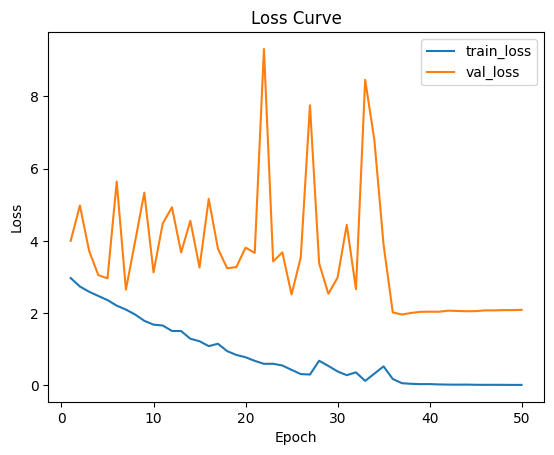

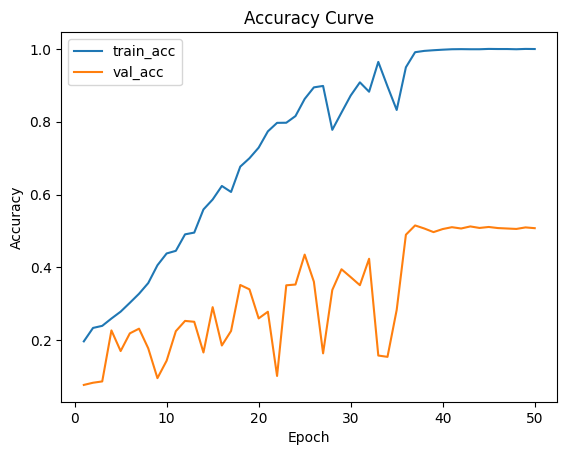

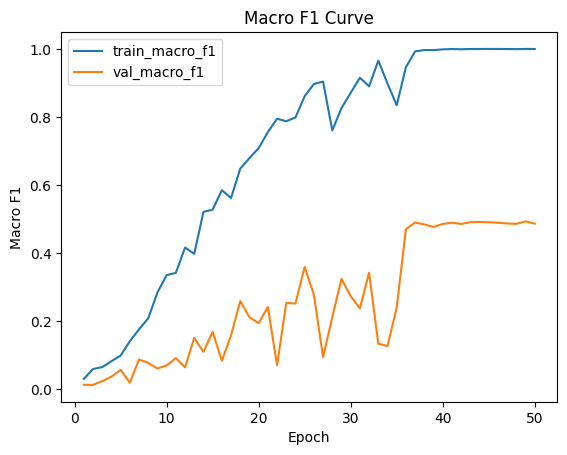

In [12]:
def plot_history(hist: History):
    epochs = range(1, len(hist.train_loss) + 1)

    plt.figure()
    plt.plot(epochs, hist.train_loss, label="train_loss")
    plt.plot(epochs, hist.val_loss, label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, hist.train_acc, label="train_acc")
    plt.plot(epochs, hist.val_acc, label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, hist.train_f1, label="train_macro_f1")
    plt.plot(epochs, hist.val_f1, label="val_macro_f1")
    plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.title("Macro F1 Curve"); plt.legend()
    plt.show()

plot_history(history)

**Evaluate on validation**

collect preds (val):   0%|          | 0/53 [00:00<?, ?it/s]


==== VALIDATION METRICS (Model3) ====
Accuracy   : 0.5097509750975098
Macro Prec : 0.534564737166789
Macro Rec  : 0.4692263325853371
Macro F1   : 0.4932298118886752

Classification Report:
                          precision    recall  f1-score   support

                     ATR       0.62      0.58      0.60        67
                  Airbus       0.45      0.52      0.48       433
                 Antonov       0.52      0.36      0.43        33
              Beechcraft       0.44      0.25      0.32        67
                  Boeing       0.53      0.62      0.57       733
    Bombardier Aerospace       0.25      0.15      0.19        34
       British Aerospace       0.71      0.57      0.64       134
                Canadair       0.55      0.65      0.60       133
                  Cessna       0.44      0.68      0.54       133
         Cirrus Aircraft       0.83      0.73      0.77        33
       Dassault Aviation       0.64      0.48      0.55        66
                 

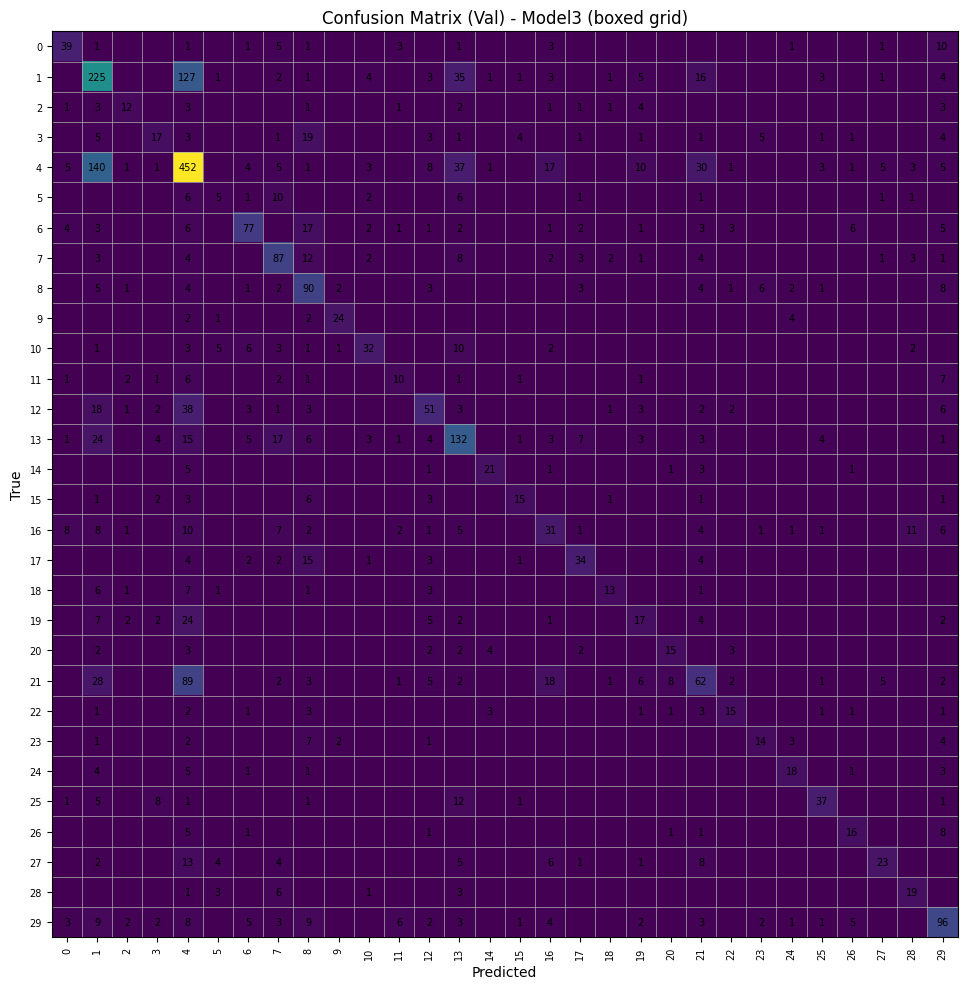


Note: Do NOT evaluate on test until your final model.


In [13]:
def collect_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="collect preds (val)", leave=False):
            images = images.to(device, non_blocking=True)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)

def plot_confusion_matrix_grid(cm, title="Confusion Matrix", max_classes_to_show=30):
    n = cm.shape[0]
    show_n = min(n, max_classes_to_show)
    cm_show = cm[:show_n, :show_n]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cm_show, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(-0.5, show_n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, show_n, 1), minor=True)
    ax.grid(which="minor", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    for i in range(show_n):
        for j in range(show_n):
            v = cm_show[i, j]
            if v != 0:
                ax.text(j, i, str(v), ha="center", va="center", fontsize=7)

    ax.set_xticks(np.arange(show_n))
    ax.set_yticks(np.arange(show_n))
    ax.set_xticklabels([str(i) for i in range(show_n)], rotation=90, fontsize=7)
    ax.set_yticklabels([str(i) for i in range(show_n)], fontsize=7)

    plt.tight_layout()
    plt.show()

y_true, y_pred = collect_preds(model, val_loader)

val_acc = accuracy_score(y_true, y_pred)
val_macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
val_macro_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
val_macro_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)

print("\n==== VALIDATION METRICS (Model3) ====")
print("Accuracy   :", val_acc)
print("Macro Prec :", val_macro_prec)
print("Macro Rec  :", val_macro_rec)
print("Macro F1   :", val_macro_f1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix_grid(cm, title="Confusion Matrix (Val) - Model3 (boxed grid)", max_classes_to_show=30)

print("\nNote: Do NOT evaluate on test until your final model.")

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


In [15]:
@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_labels, all_preds


In [16]:
y_true, y_pred = evaluate_model(model, val_loader, device)


In [17]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.5098
Precision: 0.5346
Recall   : 0.4692
F1-score : 0.4932


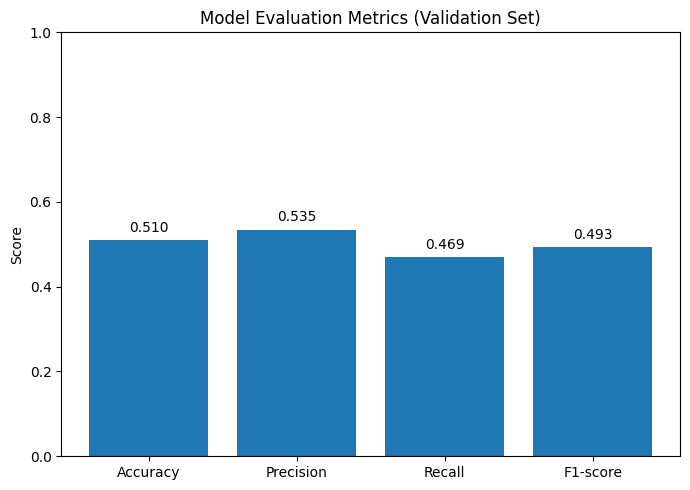

In [18]:
metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1
}

plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Model Evaluation Metrics (Validation Set)")
plt.ylabel("Score")

for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


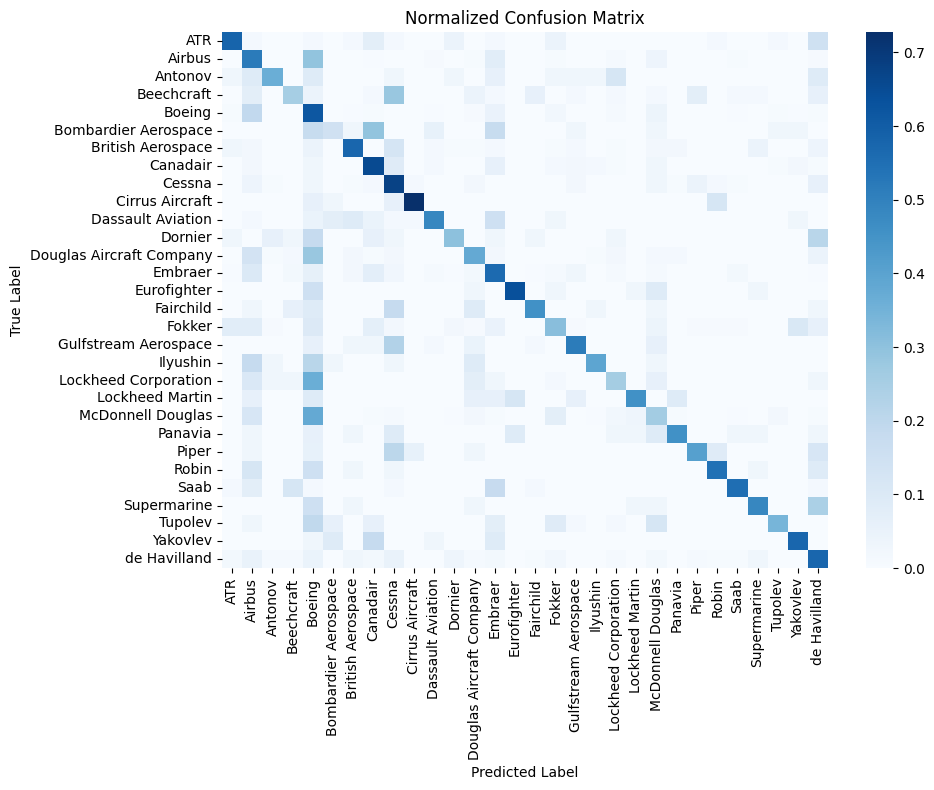

In [19]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    annot=False
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


In [20]:
miscls = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            miscls.append((class_names[i], class_names[j], cm[i, j]))

miscls = sorted(miscls, key=lambda x: x[2], reverse=True)

print("Top common misclassifications:")
for t, p, v in miscls[:10]:
    print(f"{t} → {p}: {v:.2f}")


Top common misclassifications:
McDonnell Douglas → Boeing: 0.38
Lockheed Corporation → Boeing: 0.36
Bombardier Aerospace → Canadair: 0.29
Airbus → Boeing: 0.29
Beechcraft → Cessna: 0.28
Douglas Aircraft Company → Boeing: 0.28
Supermarine → de Havilland: 0.24
Gulfstream Aerospace → Cessna: 0.23
Dornier → de Havilland: 0.21
Ilyushin → Boeing: 0.21


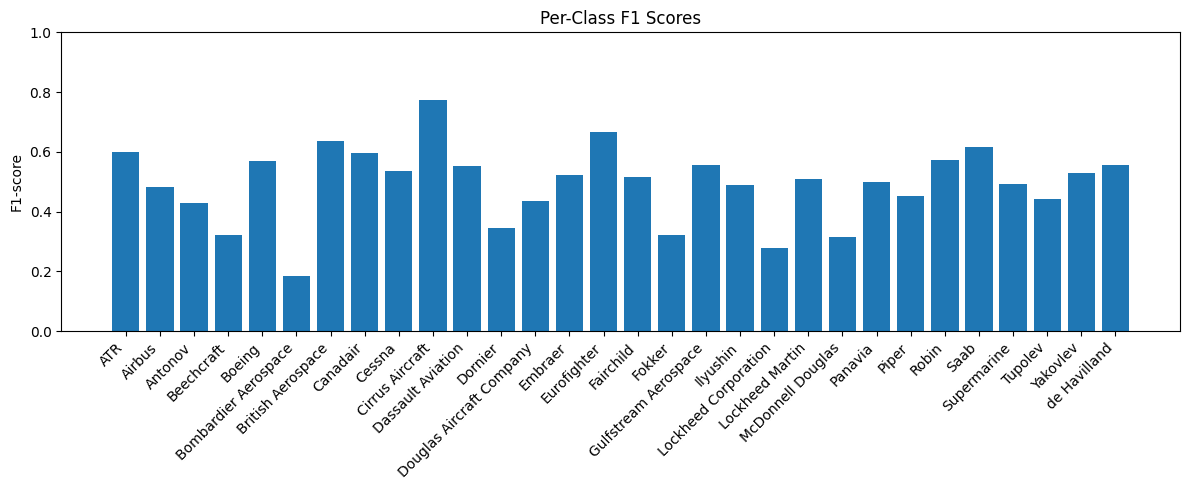

In [21]:
from sklearn.metrics import f1_score

per_class_f1 = f1_score(
    y_true, y_pred,
    average=None,
    zero_division=0
)

plt.figure(figsize=(12, 5))
plt.bar(class_names, per_class_f1)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.title("Per-Class F1 Scores")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()
